# Analyze open data sets with pandas DataFrames

In this notebook, you'll learn how to use open data from the data sets on the Data Science Experience home page in a Python notebook. You will load, clean, and explore the data with pandas DataFrames. 

Some familiarity with Python is recommended.

The data sets for this notebook are from the World Development Indicators (WDI) data set. The WDI data set is a statistical benchmark that helps measure the progress of human development. The WDI data set draws on data from the World Bank and more than 30 partners. You'll look at seven key development variables, sorted by country and year.

## Learning goals

1. Access data from the Data Science Experience home page.
1. Merge multiple data sets in pandas DataFrames.
1. Structure data for analysis.
1. Generate summary statistics.
1. Create charts with custom formatting.
1. Show relationships between all variables.

In [1]:
# Import Some Modules
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib; matplotlib.style.use('ggplot')

# inline plots
%matplotlib inline

## Table of contents
The main parts of this notebook are:
1. [Load data into DataFrames](#load)
    1. [Load the first data set](#first)
    1. [Load another data set](#loadsecond)
    1. [Join the DataFrames](#joindataframes)
    1. [Add more data](#loadmore)
    1. [Create a MultiIndex](#multiindex)
1. [Check the data](#check)
1. [Analyze the data](#analysis)
    1. [Create scatter plots with matplotlib](#matplotlib)
    1. [Create a scatter plot matrix](#matrix)
1. [Next steps](#summary)

<a id="load"></a>
## 1. Load data into DataFrames

To load the data, you obtain access key links and put them into the code to create pandas DataFrames. You will load data into multiple DataFrames and then merge the DataFrames and create a MultiIndex to structure the data for analysis.

<a id="first"></a>
### A. Load the first data set

The first data set that you'll load contains life expectancy data.

To get your access key link and load the first data set:
1. Find the data set and get the access key link:
    1. On the Data Science Experience home page, search for "life expectancy."
    1. Click the card with the title [Life expectancy at birth by country in total years](https://apsportal.ibm.com/exchange/public/entry/view/f15be429051727172e0d0c226e2ce895).
    1. Click the link button.
    1. Hover above the link button next to the access key to display the link.
    1. Double-click the link to select it, copy the link, and click **Close**.
    1. Insert the access key link and run the cell to load the data:
    1. In the cell below, replace the **LINK-TO-DATA** string in the `read_csv()` method with the link.
    1. Run the following cell to import the pandas and numpy libraries, rename and load three columns of the data into the DataFrame, and show the first five rows of data.

In [2]:
# life expectancy at birth in years
life = pd.read_csv("data/UNdata_life_expectancy_at_birth_total_years.csv",usecols=['Country or Area','Year','Value'])
life.columns = ['country','year','life']
life.head(20)

,country,year,life
0,Afghanistan,2012,60.509122
1,Afghanistan,2011,60.065366
2,Afghanistan,2010,59.600098
3,Afghanistan,2009,59.112341
4,Afghanistan,2008,58.607098
5,Afghanistan,2007,58.091366
6,Afghanistan,2006,57.570659
7,Afghanistan,2005,57.058439
8,Afghanistan,2004,56.569732
9,Afghanistan,2003,56.107561


<a id="loadsecond"></a>
### B. Load another data set

The life expectancy figures are more meaningful if you combine them with other data sets. Get an access key link for this data set: [Total population by country](https://apsportal.ibm.com/exchange/public/entry/view/889ca053a19986a4445839358a91963e). Paste your link in the following cell, which loads three columns of the data and prints the number of countries in each data set: 

In [3]:
# population
population = pd.read_csv("data/UNdata_population_total.csv",usecols=['Country or Area', 'Year','Value'])
population.columns = ['country', 'year','population']
population.head(5)

,country,year,population
0,Afghanistan,2013,30551674.0
1,Afghanistan,2012,29824536.0
2,Afghanistan,2011,29105480.0
3,Afghanistan,2010,28397812.0
4,Afghanistan,2009,27708187.0


In [4]:
print "Nr of countries in life:", np.size(np.unique(life['country']))
print "Nr of countries in population:", np.size(np.unique(population['country']))

Nr of countries in life: 246
Nr of countries in population: 245


In [5]:
life.year.dtype

dtype('O')

In [6]:
population.year.dtype

dtype('int64')

### Masking and Data Scrubbing
Data is sometimes (ALWAYS) dirty. To make analysis easy, we have to first "scrub" them
* Remove Bad entries
* Filter/ Fill missing NAN values (or not!)

In [7]:
# Using masks and apply lambda functions!
# A mask is just a boolean dataframe/series with dimensions of the original dataframe

life[life.year.apply(lambda x: not x.isdigit())].head()

,country,year,life
11969,footnoteSeqID,Footnote,NaN
11970,2,Derived using linearly extrapolated data,NaN
11971,3,Derived using linearly interpolated data,NaN
11972,4,Derived using extrapolated data assuming the s...,NaN
11973,5,Derived using interpolated data,NaN


In [8]:
# Remove non-numeric rows!
life = life[life.year.apply(lambda x: x.isdigit())]

In [9]:
# Change to Float (preferred numeric format of dataframe)
life['year'] = life['year'].astype(float)
population['year'] = population['year'].astype(float)

In [10]:
life.info()
print ""
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11969 entries, 0 to 11968
Data columns (total 3 columns):
country    11969 non-null object
year       11969 non-null float64
life       11969 non-null float64
dtypes: float64(2), object(1)
memory usage: 374.0+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13121 entries, 0 to 13120
Data columns (total 3 columns):
country       13121 non-null object
year          13121 non-null float64
population    13091 non-null float64
dtypes: float64(2), object(1)
memory usage: 307.6+ KB


## Join DataFrames

As you can see, the two data sets don't fit together perfectly: one contains more countries than the other. When you join two DataFrames, it's common to introduce nulls or NaNs (a value that's not a number when a number is expected) into the resulting DataFrame. 

Use the pandas `merge` function to make the data fit together. In the following cell, the `how='outer'` option specifies to keep the data from the `life` and `population` columns. The `on=['country','year']` option specifies which columns to merge on. To view the options for the `merge` function, see [Merge, join, and concatentate](http://pandas.pydata.org/pandas-docs/stable/merging.html). 

In [11]:
df = pd.merge(life, population, how='outer', sort=True, on=['country','year'])

In [12]:
# Check integrity of data
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13124 entries, 0 to 13123
Data columns (total 4 columns):
country       13124 non-null object
year          13124 non-null float64
life          11969 non-null float64
population    13091 non-null float64
dtypes: float64(3), object(1)
memory usage: 512.7+ KB


country          0
year             0
life          1155
population      33
dtype: int64

In [13]:
df.head()

,country,year,life,population
0,Afghanistan,1960.0,31.580049,8774440.0
1,Afghanistan,1961.0,32.095976,8953544.0
2,Afghanistan,1962.0,32.611878,9141783.0
3,Afghanistan,1963.0,33.127317,9339507.0
4,Afghanistan,1964.0,33.641244,9547131.0


In [14]:
df.groupby("country").mean().sort_values("population", ascending = False).head(10)

,year,life,population
country,,,
World,1986.5,63.752502,5.008097e+09
Low & middle income,1986.5,60.697168,3.904088e+09
Middle income,1986.5,61.954126,3.418550e+09
Upper middle income,1986.5,65.769969,1.778217e+09
East Asia & Pacific (all income levels),1986.5,66.344457,1.695653e+09
Lower middle income,1986.5,57.737533,1.640333e+09
East Asia & Pacific (developing only),1986.5,65.107053,1.490551e+09
High income,1986.5,73.603806,1.104008e+09
South Asia,1986.5,56.502828,1.078283e+09


In [15]:
# We Need More Lemon Pledge!
filter_countries = ["World", "High income", "Low & middle income", "Middle income",\
                    "Lower middle income", "Upper middle income","Low income", "East Asia & Pacific (all income levels)",\
                    "East Asia & Pacific (developing only)", "South Asia", "OECD members", "High income: OECD",\
                    "Sub-Saharan Africa (all income levels)", "Sub-Saharan Africa (developing only)",\
                    "Europe & Central Asia (all income levels)", "Least developed countries: UN classification",\
                    "Heavily indebted poor countries (HIPC)", "Latin America & Caribbean (all income levels)",\
                    "Latin America & Caribbean (developing only)", "European Union","Middle East & North Africa (all income levels)",\
                    "Middle East & North Africa (developing only)", "Euro area", "Arab World", "Europe & Central Asia (developing only)",\
                    "High income: nonOECD", "North America"
                    ]

df = df[df['country'].apply(lambda x: x not in filter_countries)]
df.sort_values("population",ascending = False).reset_index().head(10)

,index,country,year,life,population
0,2321,China,2013.0,NaN,1.357380e+09
1,2320,China,2012.0,75.199512,1.350695e+09
2,2319,China,2011.0,75.042000,1.344130e+09
3,2318,China,2010.0,74.885024,1.337705e+09
4,2317,China,2009.0,74.731634,1.331260e+09
5,2316,China,2008.0,74.579829,1.324655e+09
6,2315,China,2007.0,74.424073,1.317885e+09
7,2314,China,2006.0,74.256317,1.311020e+09
8,2313,China,2005.0,74.053902,1.303720e+09
9,2312,China,2004.0,73.793707,1.296075e+09


### This is getting boring..... Lets PLOT something

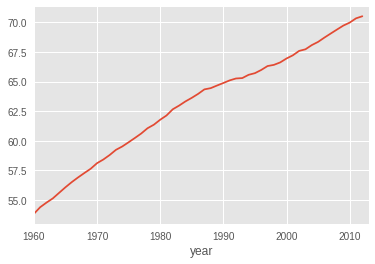

In [16]:
df.groupby('year').mean()['life'].plot()
plt.show()

In [17]:
avg_life = df.drop("year", axis = 1).groupby("country").mean().sort_values("life", ascending = False)
avg_life.head(14)

,life,population
country,,
San Marino,81.494746,2.348367e+04
Liechtenstein,79.796534,2.754563e+04
Faeroe Islands,78.152744,4.373393e+04
Iceland,77.495377,2.479294e+05
Isle of Man,77.247561,6.739013e+04
Sweden,77.157326,8.490987e+06
Japan,77.107230,1.171442e+08
Bermuda,77.011644,5.729831e+04
Switzerland,76.807119,6.688197e+06


In [18]:
avg_life.tail(20)

,life,population
country,,
Rwanda,45.709723,6.328390e+06
Guinea,45.239984,6.447129e+06
Malawi,45.063332,8.470915e+06
Nigeria,45.012043,9.415954e+07
Chad,44.755199,6.303956e+06
Central African Republic,44.615013,2.813273e+06
Equatorial Guinea,44.479256,3.957122e+05
Niger,43.852782,8.202466e+06
Mozambique,43.275768,1.451595e+07


In [19]:
median_life = df[['year','life']].groupby("year").mean()
median_life.loc[1960][0]

53.817165778737582

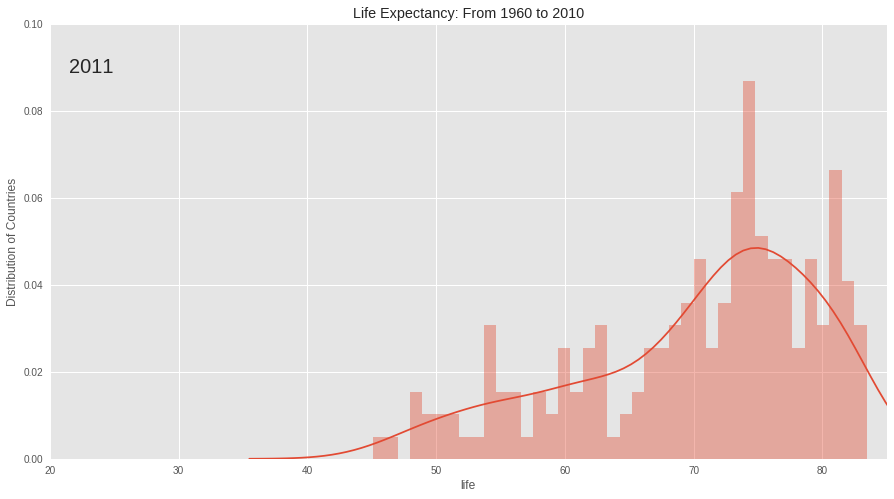

In [20]:
# Line plots are boring. How about a histogram?
import time, sys
from IPython.display import clear_output, display
from pylab import text

f, ax = plt.subplots(figsize = (15,8))

for year in range(1960,2012):
    ax.set_xlim([20,85])
    ax.set_ylim([0,0.1])
    plt.xlabel('Life Expectancy');
    plt.ylabel('Distribution of Countries');
    plt.title('Life Expectancy: From 1960 to 2010')
    text(0.05, 0.9, str(year), fontsize=20,ha='center', va='center', transform=ax.transAxes)

    data = df[df.year == year]["life"].dropna()
    sns.distplot(data,hist=True, kde=True, rug=False, bins=40);
    
#     year_df = df[df.year == year]
#     median  = median_life.loc[year][0]
#     data_low = year_df[year_df.life <= median]["life"].dropna()
#     data_high = year_df[year_df.life > median]["life"].dropna()
#     sns.distplot(data_low,hist=True, kde=True, rug=False, bins=30);
#     sns.distplot(data_high,hist=True, kde=True, rug=False, bins=30);
    
    time.sleep(0.0001)
    clear_output(True)
    display(f)
    ax.cla()

plt.close()

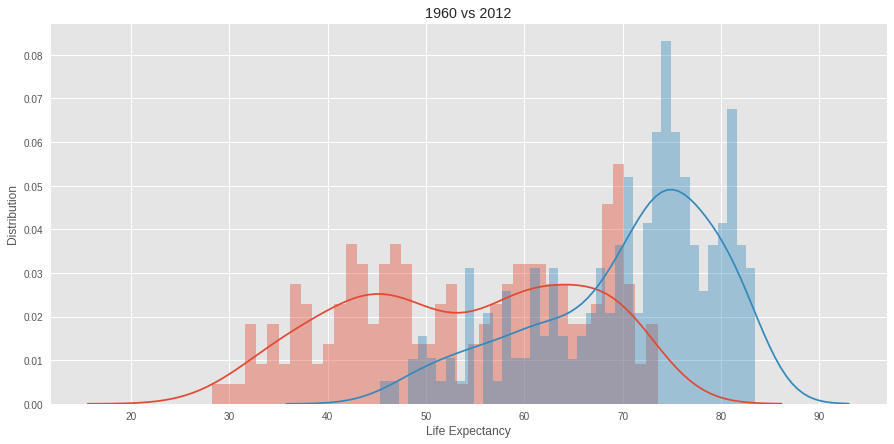

In [36]:
def hist_plot(year1, year2):
    f, ax = plt.subplots(figsize = (15,7))
    clear_output(True)
    plt.clf()
    data1 = df[df.year == year1]["life"].dropna()
    data2 = df[df.year == year2]["life"].dropna()
    sns.distplot(data1,hist=True, kde=True, rug=False, bins=40);
    sns.distplot(data2,hist=True, kde=True, rug=False, bins=40);
    
    plt.xlabel('Life Expectancy')
    plt.ylabel('Distribution')
    plt.title(str(year1) + " vs " + str(year2))
    
hist_plot(1960, 2012)

In [37]:
# use list comprehension to to extract decades
years = [year for year in range(int(df.year.min()),int(df.year.max())) if year%10==0]
years

[1960, 1970, 1980, 1990, 2000, 2010]

<function __main__.hist_plot>

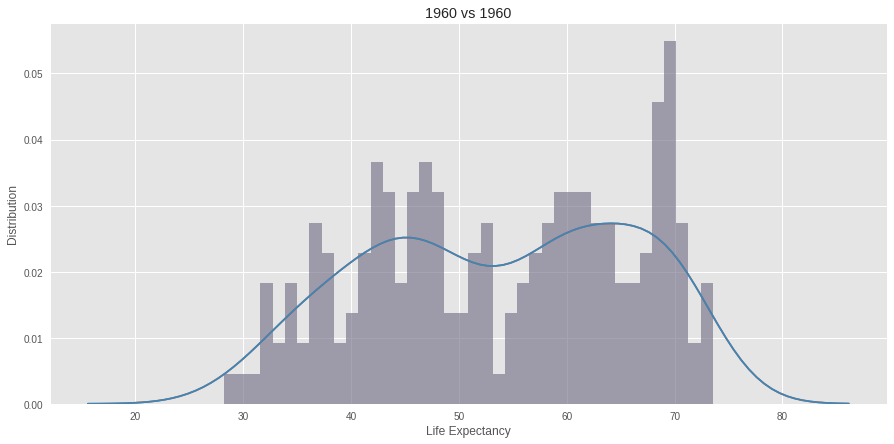

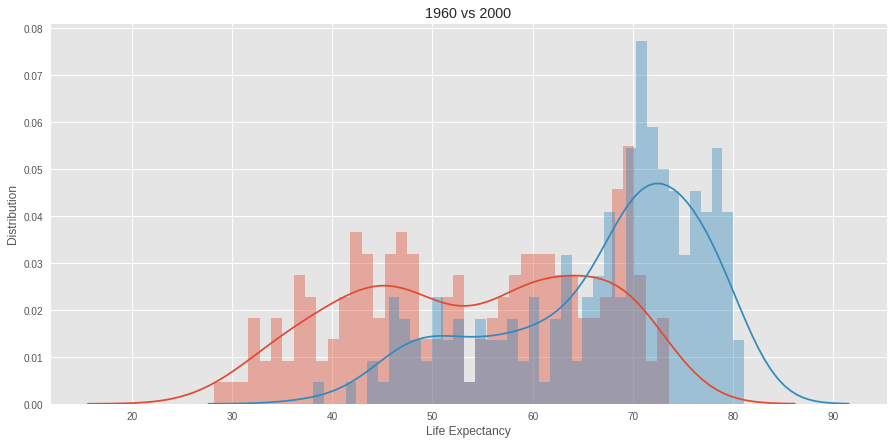

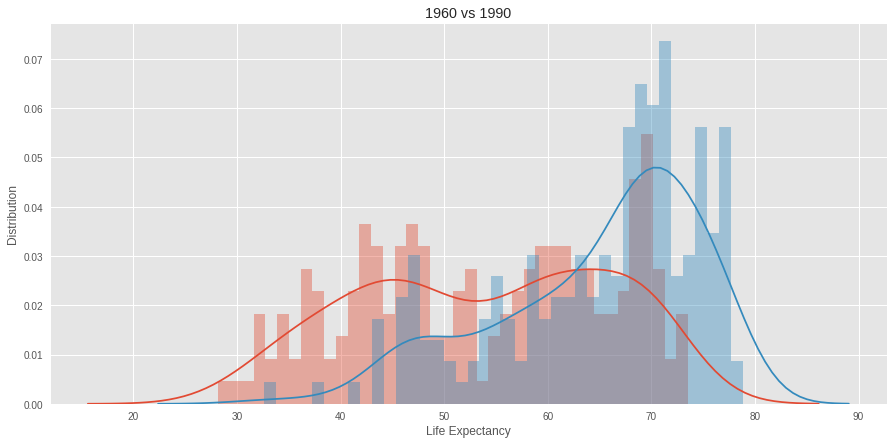

In [38]:
from ipywidgets import interact
interact(hist_plot, year1 =years, year2 =years)

<a id="loadmore"></a>
### D. Add more data 

Add more data about development to the DataFrame. For each data set, you'll include the country and year columns, plus a column that contains the key development variable for that data set. For the employment data set, you'll derive a column from three original columns.

For each of these data sets, get an access key link for the data and paste the link into the appropriate section of the following cell:
* [Population below national poverty line, total, percentage](https://apsportal.ibm.com/exchange/public/entry/view/3a42de810e682d5a83e76fda9fea2bbe)
* [Primary school completion rate % of relevant age group by country](https://apsportal.ibm.com/exchange/public/entry/view/97fc6c420265012ae9b5e9439b9ee293)
* [Total employment, by economic activity (Thousands)](https://apsportal.ibm.com/exchange/public/entry/view/21c789ae4cfadf52f1bb14b5d4a0b99c)
* [Births attended by skilled health staff (% of total) by country](https://apsportal.ibm.com/exchange/public/entry/view/87160cc8374805cb3b07dff4b4f9223e)
* [Measles immunization % children 12-23 months by country](https://apsportal.ibm.com/exchange/public/entry/view/752e36ea889eca360e989baa785c2a5e)

In [ ]:
def clean_year(df):
    if df.year.dtype not in (np.int64, np.float64):
        df = df[df.year.apply(lambda x: x.isdigit())]
    df['year'] = df['year'].astype(float)
    return df

In [ ]:
# Population below national poverty line, total, percentage
poverty = pd.read_csv("data/UNdata_Export_20151013_112943678-poverty_clean.csv",usecols=['Country or Area', 'Year','Value'])
poverty.columns = ['country', 'year','poverty']

# Primary school completion rate % of relevant age group by country
school = pd.read_csv("data/UNdata_Primary_completion_rate_total (%_relevant_age_group.csv",usecols=['Country or Area', 'Year','Value'])
school.columns = ['country', 'year','school']

# Total employment, by economic activity (Thousands)
employmentin = pd.read_csv("data/Total employment, by economic activity .csv",usecols=['Country or Area', 'Year','Value','Sex','Subclassification'])
employment = employmentin.loc[(employmentin.Sex=='Total men and women')&
                              (employmentin.Subclassification=='Total.')]
employment = employment.drop('Sex', 1)
employment = employment.drop('Subclassification', 1)
employment.columns = ['country', 'year','employment']

# Births attended by skilled health staff (% of total) by country
births = pd.read_csv("data/Births attended by skilled health staff (% of total).csv",usecols=['Country or Area', 'Year','Value'])
births.columns = ['country', 'year','births']

# Measles immunization % children 12-23 months by country
measles = pd.read_csv("data/UNdata_Immunization_measles_%_children_12to23_months.csv",usecols=['Country or Area', 'Year','Value'])
measles.columns = ['country', 'year','measles']


merge_lists = [poverty, school, employment, births, measles]
merge_lists = map(clean_year, merge_lists)

for data in merge_lists:
    print data.info() 
    print ""  

In [ ]:
for data in merge_lists:
    df = pd.merge(df, data, how='left', sort=True, on=['country','year'])
    
df.info()

In [ ]:
avg_df = df.groupby('country').mean().sort_values("population",ascending = False)
avg_df.head()

In [ ]:
avg_df_trim = avg_df[avg_df.school < avg_df.school.quantile(0.99)]

fig, ax = plt.subplots()
avg_df_trim.plot.scatter(x='school', y='life', s=avg_df['population']*0.00001,
                         grid = None,
                         figsize=(18,15), edgecolors='white', lw= 1, ax=ax)


label_threshold = avg_df_trim["population"].quantile(0.95)
for i, txt in enumerate(avg_df_trim.index):
    if avg_df_trim.loc[txt].population > label_threshold:
        ax.annotate(txt, (avg_df_trim.school[i],avg_df_trim.life[i]), size = 20, color = "Black")
    
plt.grid(False)
plt.suptitle('Life Expendency vs Education', fontsize=20)
plt.xlabel('Primary Education Completion', fontsize=18)
plt.ylabel('Life Expectency', fontsize=16)

plt.show()

<a id="multiindex"></a>
### E. Create a MultiIndex

You structure the data for analysis by creating a pandas MultiIndex. A MultiIndex is a hierarchical index that groups the data so that you can easily summarize it.
For example, by grouping by country and then by year, you can plot the average value per country for all years instead of plotting a value for every country for every year.

Run this cell to create a MultiIndex on the country and the year:

In [ ]:
df2 = df.set_index(['country','year'])

df2[5000:5020]

You can see that for the 1980s, the only data for Afghanistan is about measles immunizations. 

If you are curious about other variables, you can add more WDI data sets from the Data Science Experience home page to this DataFrame. Not all WDI data is properly formatted. You might need to clean the data before you add it. You can reuse the code samples that you just ran. Make sure that you keep checking the results by running commands like `df2[0:10]` on your tables when you load or change them. 

<a id="check"></a>
## 2. Check the data 
You can check the data with the [`describe()` method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html), which calculates basic summary statistics for each of the columns in the DataFrame (except the country and year columns). 

Run the following cell to show the number of values (count), the mean, the standard deviation (std), the minimum value, three percentiles, and the maximum value for the columns:  

In [ ]:
df2.describe()

<a id="analysis"></a>
## 3. Analyze the data
Now that you have enough sample data to work with, you can find the correlation between different variables. You'll create scatter plots that each compare two variables. 

<a id="matplotlib"></a>
### A. Create scatter plots with matplotlib

Run the following cell to create two scatter plots that relate the values of population and amount of schooling to life expectancy. Use `matplotlib` library commands to create charts with custom font, figure size, and colors. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size']=11
plt.rcParams['figure.figsize']=[8.0, 3.5]
fig, axes=plt.subplots(nrows=1, ncols=2)
df2.plot(kind='scatter', x='life', y='population', ax=axes[0], color='Blue');
df2.plot(kind='scatter', x='life', y='school', ax=axes[1], color='Red');
plt.tight_layout()

The chart on the left shows that increased life expectancy leads to higher population. Each dot represents a value for one country for one year.

The chart on the right shows that the life expectancy increases with the percentage of school completion. Each dot represents the average value for one country for all years that have data. Notice that the percentage goes up to 200% instead of 100%. This might indicate a problem with the data. You can remove the outliers and keep only the values less than 100% with a command like: `df2[df2.school>100]=float('NaN')`. Even better, you can check where these values in the original data came from. Otherwise, a range like this might indicate an error in your code. In this case, however, the values are correct because of the way the school completion data was calculated: read the description of [Primary school completion rate % of relevant age group by country](https://apsportal.ibm.com/exchange/public/entry/view/97fc6c420265012ae9b5e9439b9ee293). Percentages higher than 100 indicate that older people are finishing primary school.

<a id="matrix"></a>
### B. Create a scatter plot matrix

You can create charts that show the relationships between all variables with a scatter plot matrix. Each dot represents the average value for one country for all years that have data. 

Run the following cell to create scatter plots and histograms from the DataFrame with the `scatter_matrix()` method. Because the data does not cover the same years, group the data by country (with some loss of data). Many variables are percentages, so convert the employment figures to percentages as well. Drop the `population` column, because you don't need it anymore. 

In [ ]:
from pandas.tools.plotting import scatter_matrix

# group by country
grouped = df2.groupby(level=0)
dfgroup = grouped.mean()

# employment in % of total population
dfgroup['employment']=(dfgroup['employment']*1000.)/dfgroup['population']*100
dfgroup=dfgroup.drop('population',1)

scatter_matrix(dfgroup,figsize=(12, 12), diagonal='kde');